# Making gene set enrichment bar plots
- use qc_pipe_zc environment 

In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
import anndata as ad

In [2]:
import seaborn as sn

In [3]:
import gseapy as gp
import time

## functions

In [4]:
def get_term_new_label( enr_df, potential_seps, term_col = 'Term'):
    """This function return a list of new term label names that trim the term names based on the passed in potential separator patters.
    For example, one sep pattern can be (GO, which can make the original name such as XXX Process (GO 123) to XXX Process alone"""
    new_names = []
    for i in enr_df.index:
        new_term = enr_df[term_col].loc[i]
        for psep in potential_seps: 
            if psep in enr_df[term_col].loc[i]:
                new_term = (enr_df[term_col].loc[i]).split(sep = psep)[0]
                break 
        new_names.append( new_term.strip() )

    return new_names
    

## Load data 
- small test gene lists here

In [10]:
test_ls1 = ['S100a6', 'Ggh', 'Malat1', 'Txn1', 'Il1rn', 'Eif2s2', 'Pmepa1',
       '2200002D01Rik', 'Capg', 'Igkc', 'Egln3', 'Sprr2a2', 'Capn2', 'Hif1a',
       'Pmp22', 'Cd55', 'Sprr2a3', 'Igha', 'Ly6d', 'Mxd1', 'Cd74', 'Myof',
       'Duoxa2', 'Hoxa11os', 'Jchain', 'Hoxa9', 'Srgn', 'Hbegf', 'Dgat2',
       'AW112010', 'Hk2', 'Zfp710', 'Hoxa10', 'Pgap1', 'Cemip2', 'Cwh43',
       'Ccser1']

test_ls2 = ['Hmgcs2', 'Aldh1b1', 'Muc2', 'Cldn15', 'Cdx2', 'Gcnt3', 'Rnase4',
       'Mettl7b', 'Gstm1', 'Ces1f', 'B4galnt1', 'Acads', 'Serinc3', 'Ech1',
       'Fabp2', 'Hmgcl', 'Sult1a1', 'Hdac1', 'Selenom', 'Ugt1a1', 'Tsc22d1',
       'Tceal9', 'Acaa2', 'Gstp1', 'Etfb', 'Traf5', 'Hoxb6', 'Cyp2c55',
       'Suclg2', 'Adh5', 'Rnf186', 'Prpsap1', 'Gstp2', 'Sult1d1', 'Ugdh',
       'Suclg1', 'Ces1g', 'Idh2', 'Mpst', 'Adk', 'Ociad2', 'Selenow', 'Klk1',
       'Cnbp', '4931406C07Rik', 'Hsd3b3', 'Eci1', 'Elapor1', 'Oat', 'Pibf1',
       'Acsf2', 'Mrpl28', 'Akr1c13', 'Ucp2', 'Eef1g', 'Pebp1', 'Gstm3', 'Qdpr',
       'Gfus', 'Ugt1a10', 'Mt2', 'B4galnt2', 'Surf1', 'Yipf1', 'Coa3',
       'Mettl26', 'Etfa', 'Bdh1', 'Ces1d', 'Aamdc']

## selecting gene set libraries

In [11]:
gpl = gp.get_library_name(organism='Mouse')

In [12]:
len(gpl)

233

In [13]:
#gpl[0:50]

In [14]:
#gpl[50:100]

In [15]:
#gpl[100:150]

In [16]:
# selected sets
GENE_SETS = ['WikiPathways_2019_Mouse', 'KEGG_2019_Mouse', 'MSigDB_Hallmark_2020', 
             'GO_Biological_Process_2023','Reactome_2022', 'GO_Molecular_Function_2023', 'NCI-Nature_2016']

### Getting enriched terms

In [17]:
MAX_GENE_NUM = 50 # or 100 if having more genes

#gene lists are already sorted based on scores
gene_lists = [ test_ls1, test_ls2 ] 
gene_lists_names = [ 'Test enriched gene list 1', 'Test enriched gene list 2']

In [18]:
enr_res_ls = [] #a list to save the enrichment result dataframe

for g in gene_lists:
    
    # get top 50 DGs
    g = list( g)
    g = g[0: min( len(g), MAX_GENE_NUM ) ]
    
    # got enrichment
    total_res_df = pd.DataFrame() 

    # make sure set number of enrichment terms from each gene set library
    for i in range(len( GENE_SETS) ):
        gs = GENE_SETS[i]
        print( GENE_SETS[i] )
        enr = gp.enrichr(gene_list=g, # use no more than MAX_GENE_NUM top DGs
                         gene_sets=GENE_SETS[i],
                         organism='mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk
                        )
        time.sleep(0.5) # make sure enough time between query, otherwise will cause database connection error
        
        # save to result df
        if( total_res_df.shape[0] < 1 ):
            total_res_df = enr.results
        else:
            print('append')
            total_res_df = pd.concat( [total_res_df, enr.results], axis = 0, ignore_index= True )

    enr_res_ls.append( total_res_df )


WikiPathways_2019_Mouse
KEGG_2019_Mouse
append
MSigDB_Hallmark_2020
append
GO_Biological_Process_2023
append
Reactome_2022
append
GO_Molecular_Function_2023
append
NCI-Nature_2016
append
WikiPathways_2019_Mouse
KEGG_2019_Mouse
append
MSigDB_Hallmark_2020
append
GO_Biological_Process_2023
append
Reactome_2022
append
GO_Molecular_Function_2023
append
NCI-Nature_2016
append


In [19]:
len( enr_res_ls )

2

## Visualizing enriched terms

In [20]:
cmap = plt.get_cmap('Set3')  # Get the 'viridis' colormap

num_colors = 7
colors = [cmap(i / num_colors) for i in range(num_colors)]

In [21]:
enr_res_ls[0].head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,Macrophage markers WP2271,1/10,0.018351,0.167863,0,0,61.586420,246.227915,CD74
1,WikiPathways_2019_Mouse,"Complement Activation, Classical Pathway WP200",1/17,0.031001,0.167863,0,0,34.630208,120.296366,CD55
2,WikiPathways_2019_Mouse,Hypertrophy Model WP202,1/20,0.036374,0.167863,0,0,29.157895,96.626651,HBEGF
3,WikiPathways_2019_Mouse,Triacylglyceride Synthesis WP386,1/23,0.041717,0.167863,0,0,25.178030,79.986447,DGAT2
4,WikiPathways_2019_Mouse,Prostaglandin Synthesis and Regulation WP374,1/31,0.055827,0.167863,0,0,18.456481,53.256097,S100A6


6
6


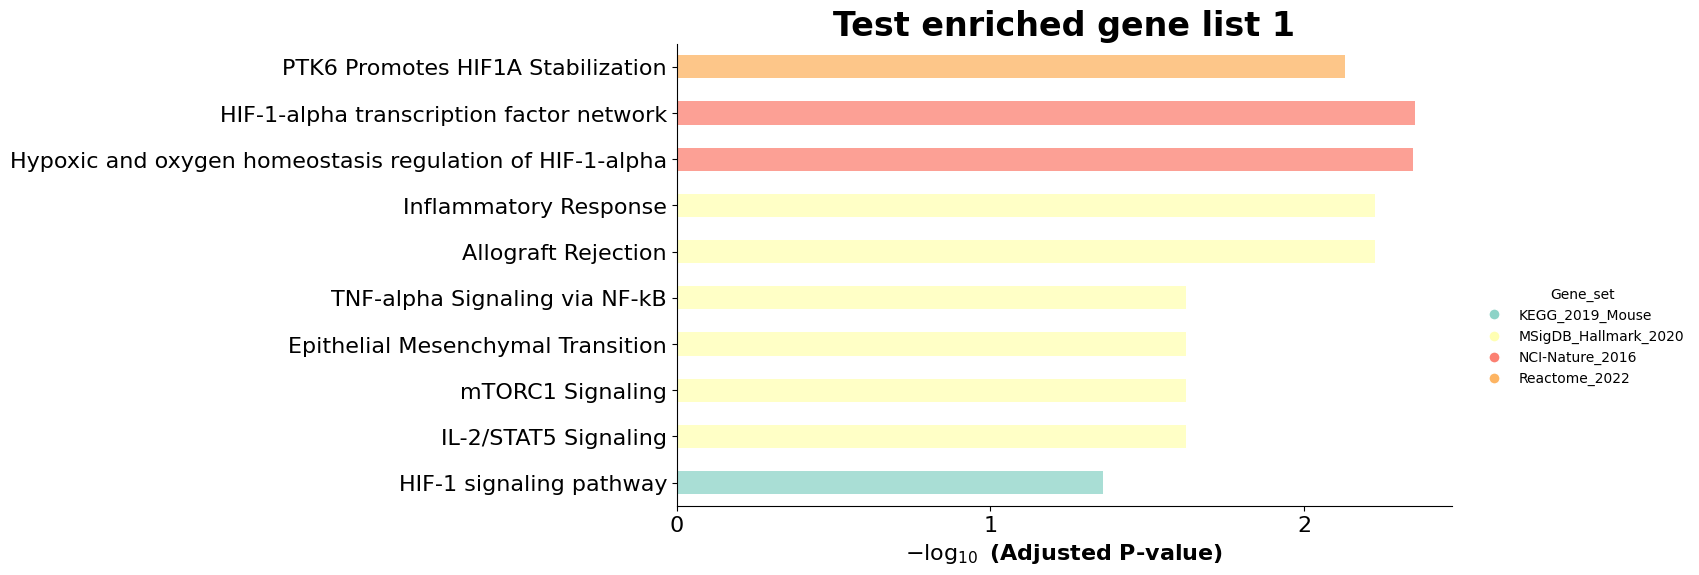

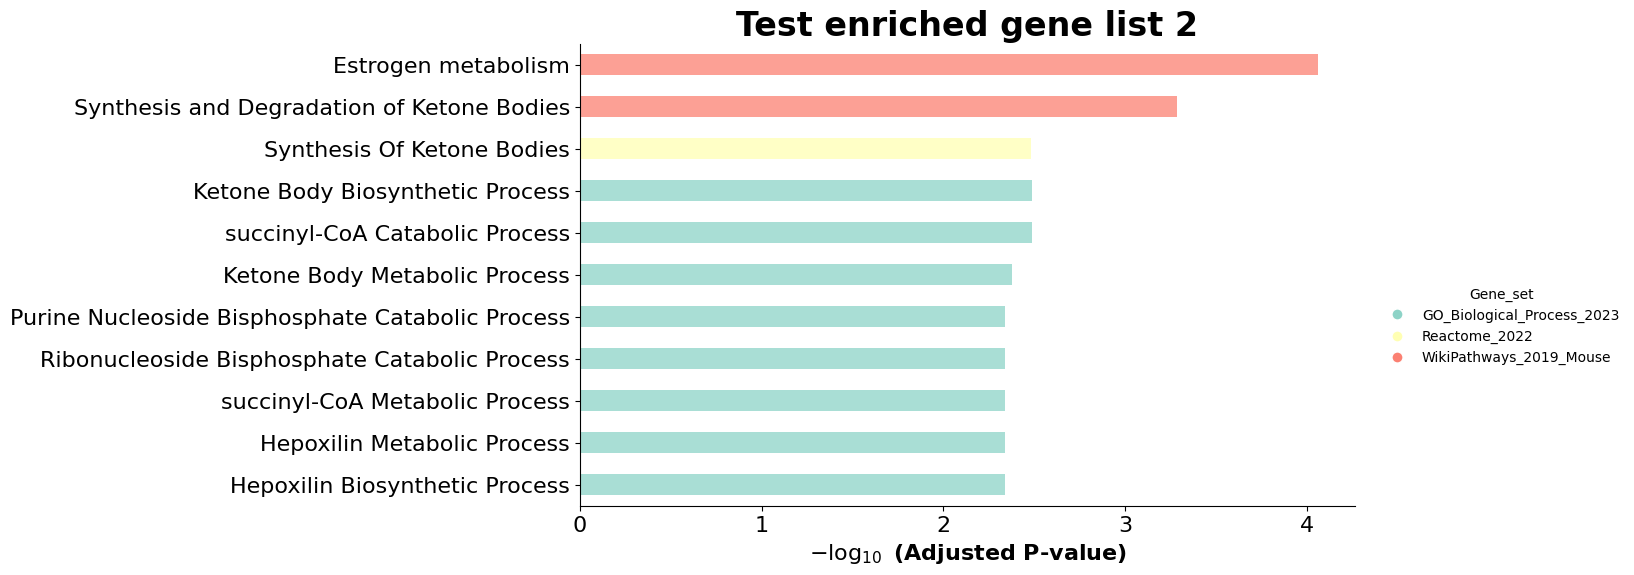

In [22]:
PLOT_TOP_TERMS = 10

for ri, raw_res_df in enumerate( enr_res_ls):
    
    plot_df = pd.DataFrame()
    gs_num_plot_terms = [] # how many terms will be plotted for each gene set

    #getting the top 5 terms based on scores
    for i in  range(len( GENE_SETS)):
        # sort based on score
        raw_res_df.sort_values( by = 'Combined Score', inplace= True, ascending=False)

        #include only significant ones and top ones
        sig_term = raw_res_df[raw_res_df['Adjusted P-value'] < 0.05 ]
        
        gs_num_plot_terms.append( min( PLOT_TOP_TERMS, sig_term.shape[0] ) )
                                 
        plot_df = pd.concat( [ plot_df, sig_term.head(PLOT_TOP_TERMS) ], axis = 0, ignore_index= True )

    # get rid of non-informative words in the term names
    new_names = get_term_new_label( plot_df, potential_seps = ['WP' , 'R-HSA' , 'Homo', '(GO' ] )
    
    plot_df['term_full_name'] = plot_df['Term'].copy()
    plot_df['Term'] = new_names
    plot_df.drop_duplicates( subset = 'Term', inplace = True )

    fig_height = int( 0.6* plot_df.shape[0]) 
    print( fig_height )
    if( plot_df.shape[0] >  0): 
        t = gp.plot.barplot(plot_df, title=gene_lists_names[ri],
                    group = 'Gene_set',
                    column='Adjusted P-value',
                    top_term=PLOT_TOP_TERMS, figsize=(10, fig_height) , color = colors,)
    
    